# Imminent ICU Admission Classifier with Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [2]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/lr'),
 'figdir': PosixPath('../data/workdir/figures'),
 'dataset_csv': PosixPath('../data/modelready_mm.csv'),
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'str_cols_pkl': PosixPath('../data/str_cols.pkl'),
 'structured_threshold': 0.53,
 'unstructured_threshold': 0.41,
 'mm_threshold': 0.45}

## Load Data

In [3]:
str_cols = pickle.load(open(args.str_cols_pkl, 'rb'))
cols = ['hadm_id'] + str_cols + ['note', 'imi_adm_label']

In [4]:
mm_notes_vitals = pd.read_csv(args.dataset_csv, usecols=cols)
mm_notes_vitals = mm_notes_vitals[mm_notes_vitals['imi_adm_label'] != -1].reset_index(drop=True)

notes_common = mm_notes_vitals[['hadm_id', 'note', 'imi_adm_label']].copy().reset_index(drop=True)
vitals_common = mm_notes_vitals[['hadm_id'] + str_cols + ['imi_adm_label']].copy().reset_index(drop=True)

print(vitals_common.shape, notes_common.shape, mm_notes_vitals.shape, vitals_common['hadm_id'].nunique(), notes_common['hadm_id'].nunique(), mm_notes_vitals['hadm_id'].nunique())

(33870, 50) (33870, 3) (33870, 51) 4003 4003 4003


In [5]:
seed = 643
save = True

In [30]:
# seeds = [643] + list(range(127,227))

# for seed in tqdm(seeds, desc='seed #'):
#   df = set_group_splits(notes_common.copy(), group_col='hadm_id', seed=seed)

#   train_df = df[df['split'] == 'train']
#   test_df = df[df['split'] == 'test']
  
#   vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
#   x_note_train = vectorizer.fit_transform(train_df['note'])
#   x_note_test = vectorizer.transform(test_df['note'])

#   with open(args.vectordir/f'bigram_{seed}.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)
#     pickle.dump(x_note_train, f)
#     pickle.dump(x_note_test, f)  

## Structured Classifier Dev

In [6]:
df = set_group_splits(vitals_common.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [7]:
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_vitals_train, x_vitals_test = train_df[str_cols].values, test_df[str_cols].values
x_vitals_train.shape, x_vitals_test.shape

((27752, 48), (6118, 48))

In [8]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_vitals_train, y_train)

prob = clf.predict_proba(x_vitals_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/phd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Sensitivity')

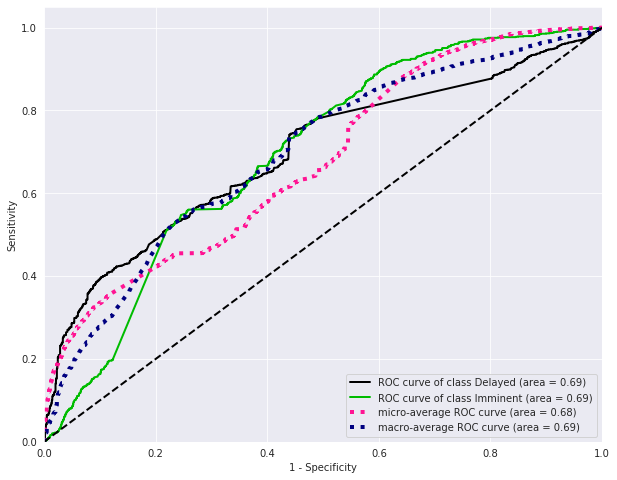

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

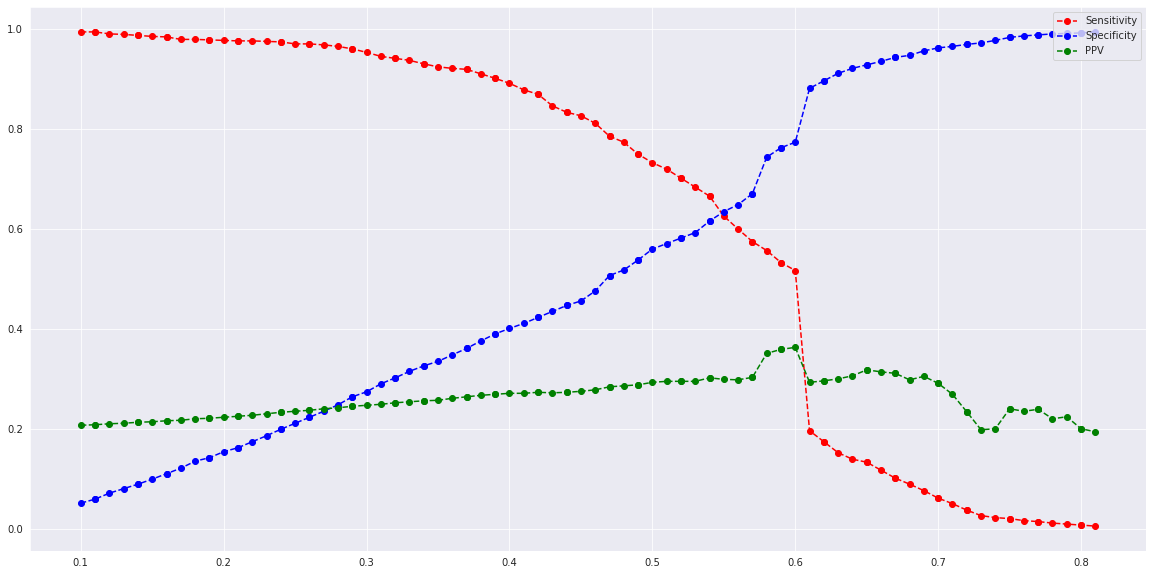

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'lr_structured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.58


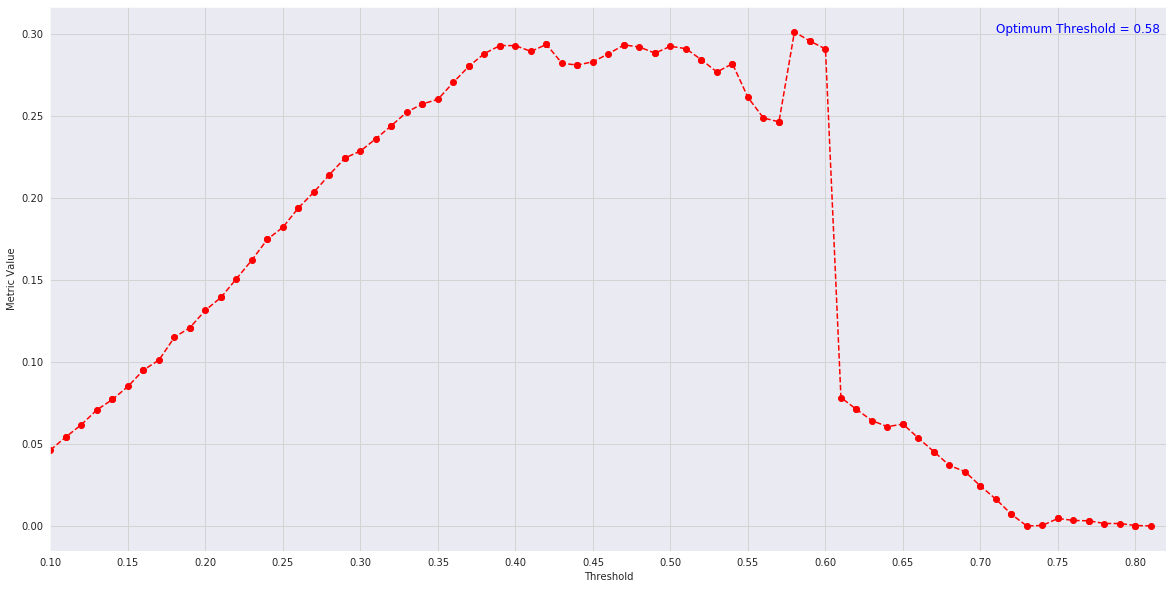

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'lr_structured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [12]:
threshold = 0.53
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.684
specificity,0.593
ppv,0.295
npv,0.883
f1,0.412
auroc,0.695
threshold,0.530


In [ ]:
# fig, ax = plt.subplots(figsize=(11, 8))
# plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

## Unstructured Data Classifier Dev

In [13]:
df = set_group_splits(notes_common.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [14]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.vectordir/f'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [15]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

((27752, 60000), (6118, 60000), (27752,), (6118,))

In [16]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_note_train, y_train)

prob = clf.predict_proba(x_note_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/phd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Sensitivity')

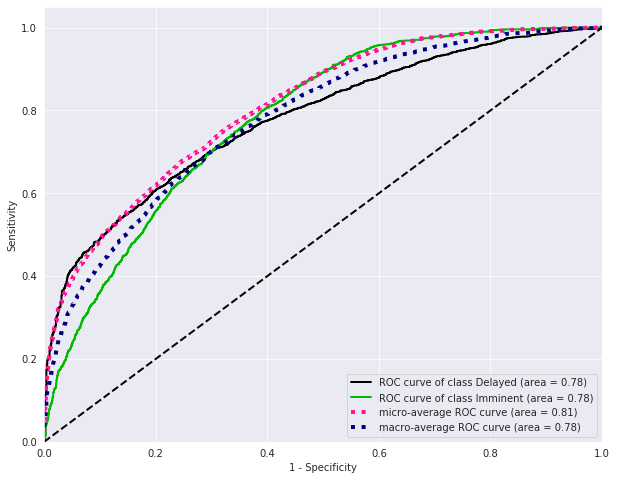

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

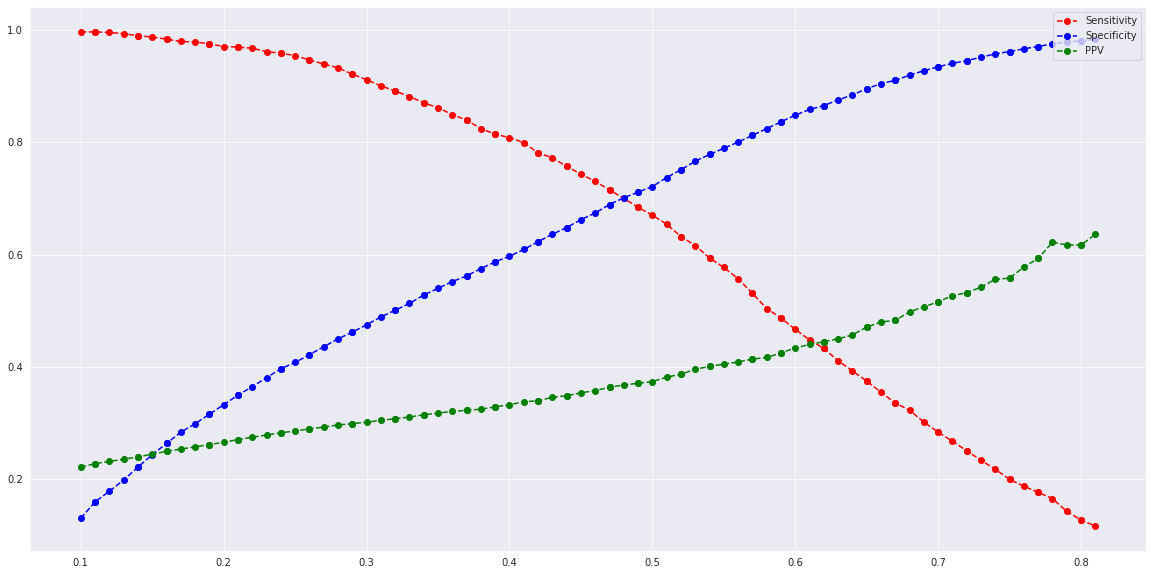

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'lr_unstructured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.41


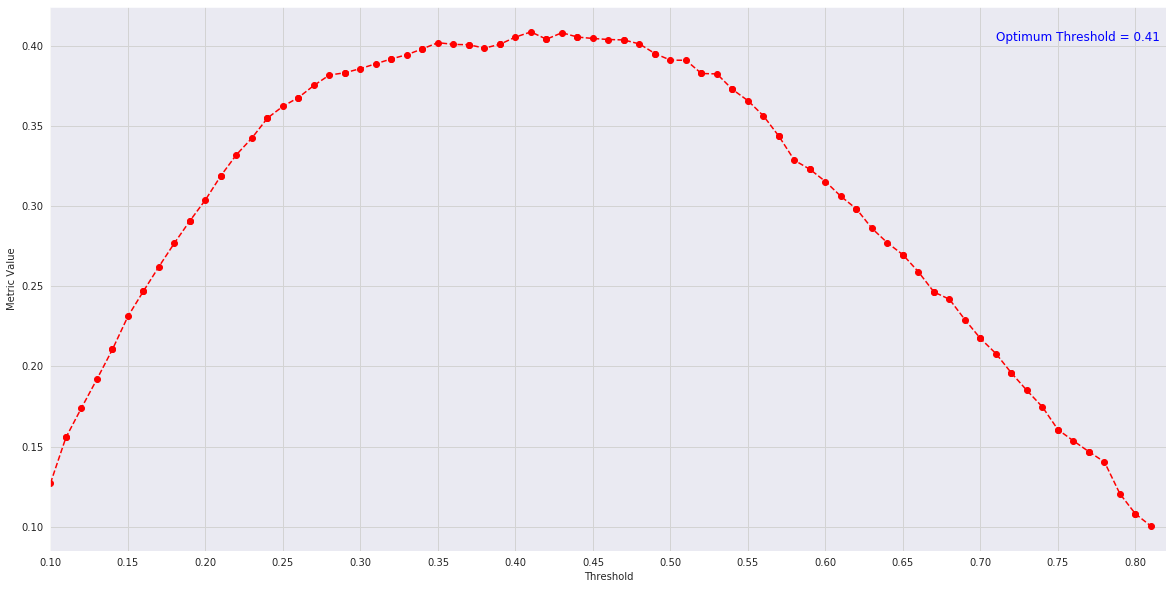

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'lr_unstructured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [20]:
threshold = 0.41
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.799
specificity,0.609
ppv,0.338
npv,0.924
f1,0.475
auroc,0.780
threshold,0.410


## Multimodal Classifier Dev

In [21]:
df = set_group_splits(mm_notes_vitals.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [22]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

((27752, 60000), (6118, 60000), (27752,), (6118,))

In [23]:
x_vitals_train, x_vitals_test = train_df[str_cols].values, test_df[str_cols].values
x_vitals_train.shape, x_vitals_test.shape

((27752, 48), (6118, 48))

In [24]:
x_train = scipy.sparse.hstack((x_vitals_train, x_note_train)).tocsr()
x_test = scipy.sparse.hstack((x_vitals_test, x_note_test)).tocsr()
x_train.shape, x_test.shape

((27752, 60048), (6118, 60048))

In [25]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/phd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Sensitivity')

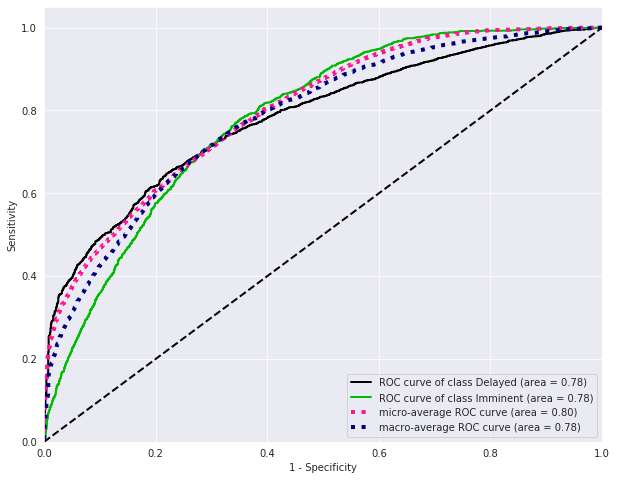

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

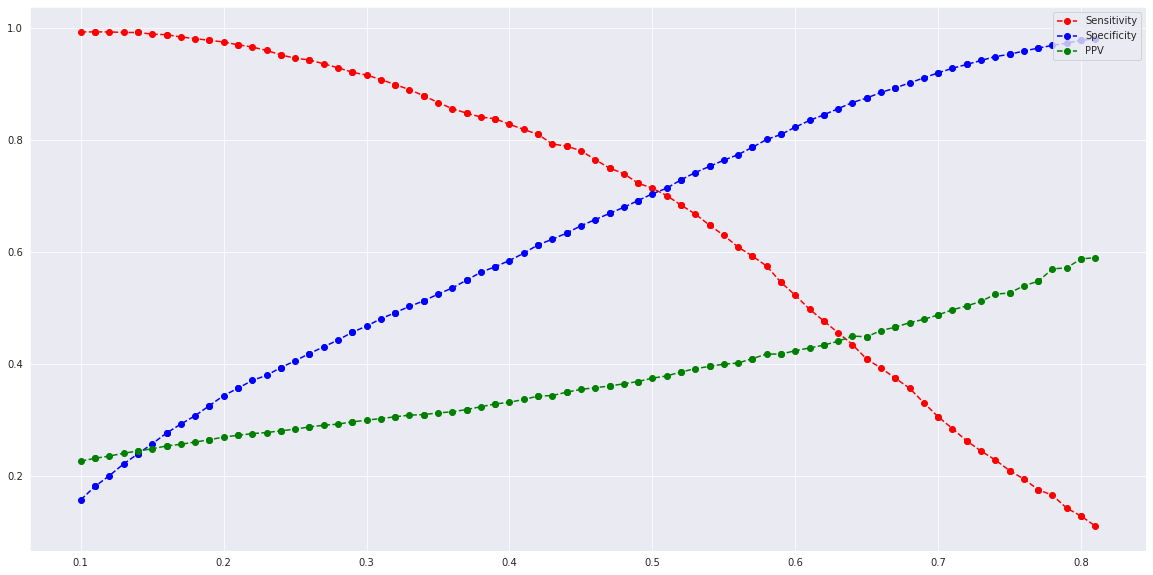

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'lr_mm_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.45


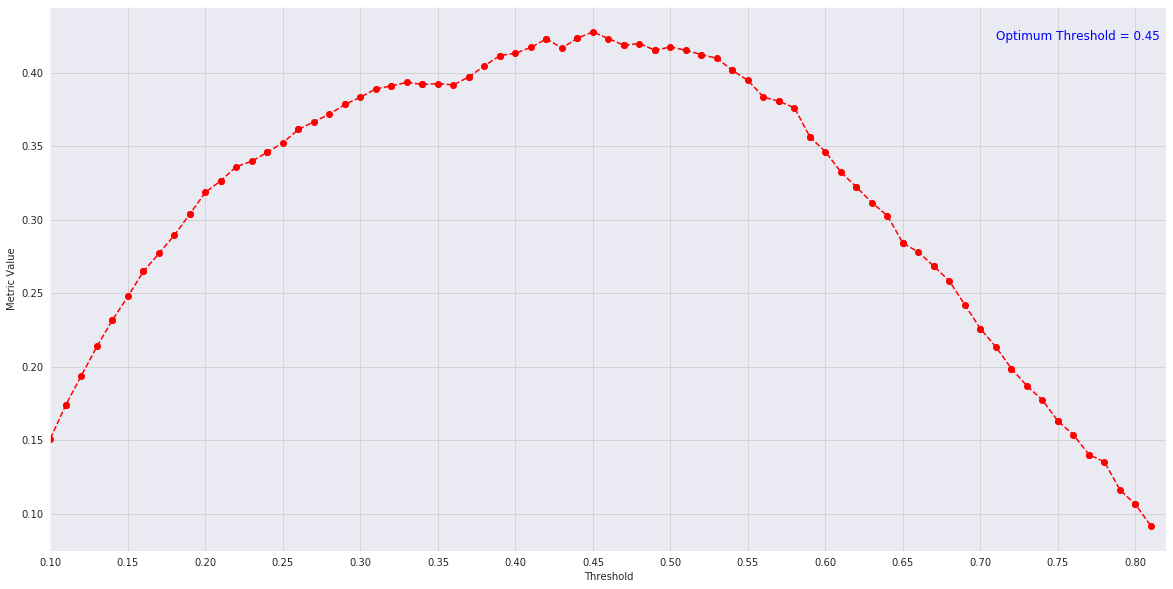

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'lr_mm_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [29]:
threshold = 0.45
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.781
specificity,0.647
ppv,0.355
npv,0.922
f1,0.488
auroc,0.783
threshold,0.450


## Metrics

In [3]:
save = True

In [4]:
with open(args.workdir/f's_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.716,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.558,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.321,"When it PREDICTS YES, how often is it correct?"
auroc,0.679,Indicates how well the model is capable of distinguishing between classes
npv,0.871,"When it PREDICTS NO, how often is it correct?"
f1,0.442,Harmonic mean of sensitivity and ppv


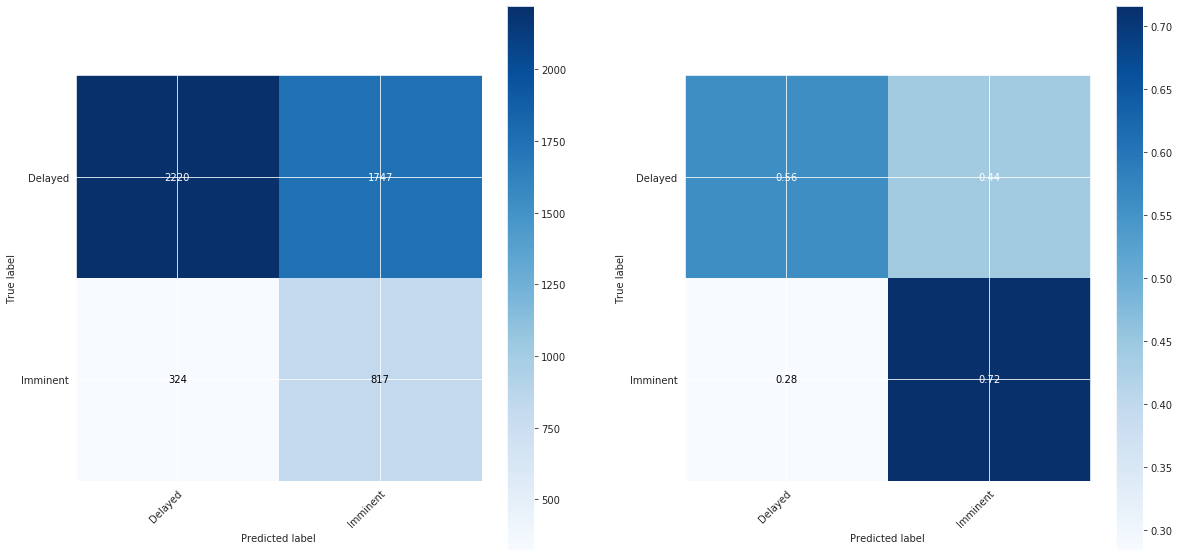

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_s_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

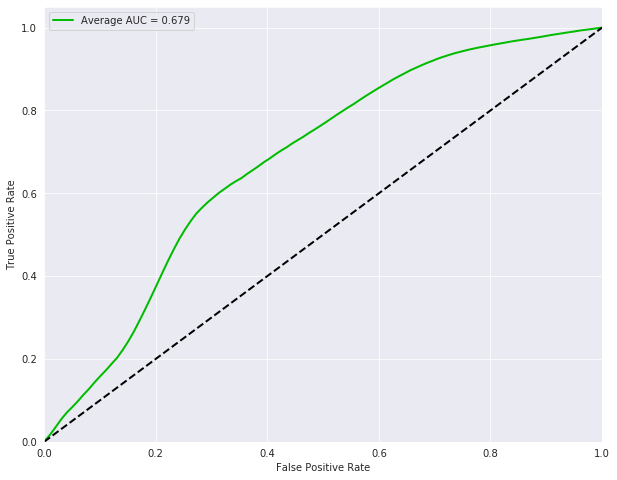

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_s_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [16]:
with open(args.workdir/f'u_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.802,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.583,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.358,"When it PREDICTS YES, how often is it correct?"
auroc,0.763,Indicates how well the model is capable of distinguishing between classes
npv,0.910,"When it PREDICTS NO, how often is it correct?"
f1,0.494,Harmonic mean of sensitivity and ppv


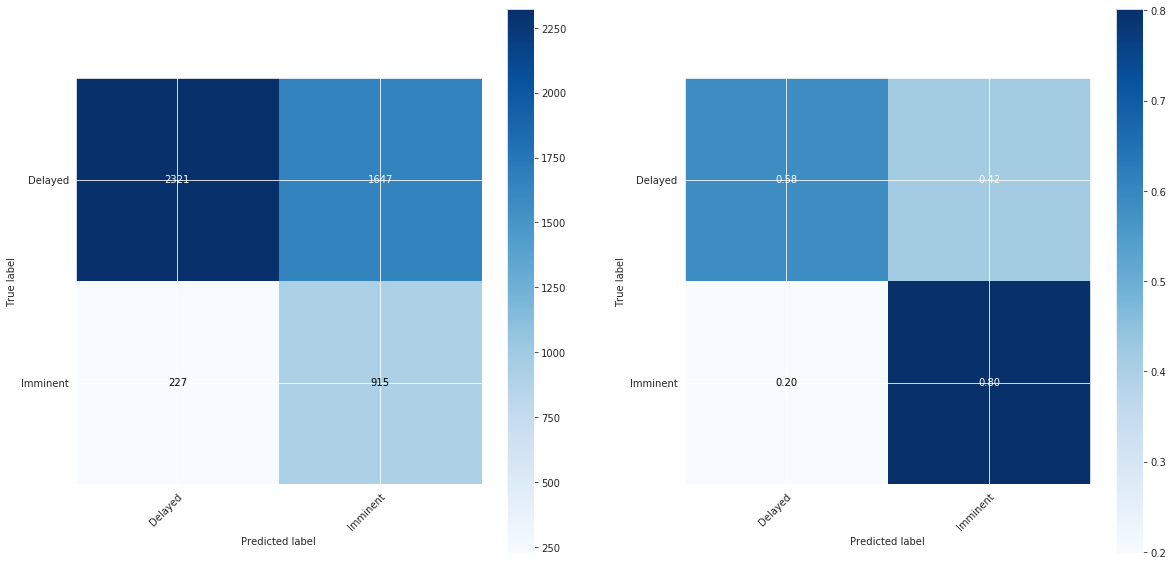

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_u_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

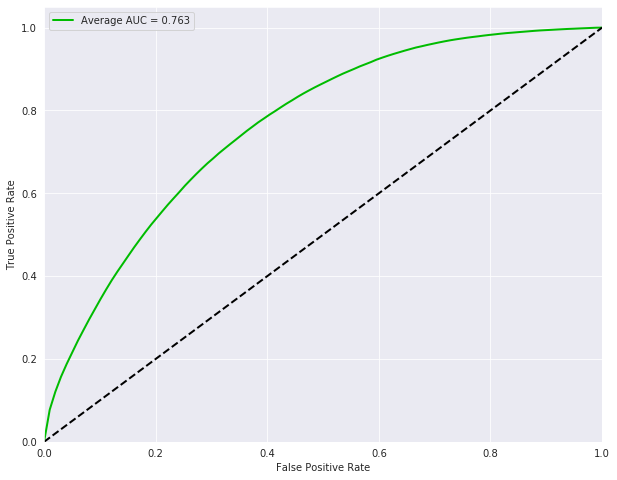

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_u_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [21]:
with open(args.workdir/f'u+s_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.803,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.597,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.366,"When it PREDICTS YES, how often is it correct?"
auroc,0.768,Indicates how well the model is capable of distinguishing between classes
npv,0.913,"When it PREDICTS NO, how often is it correct?"
f1,0.503,Harmonic mean of sensitivity and ppv


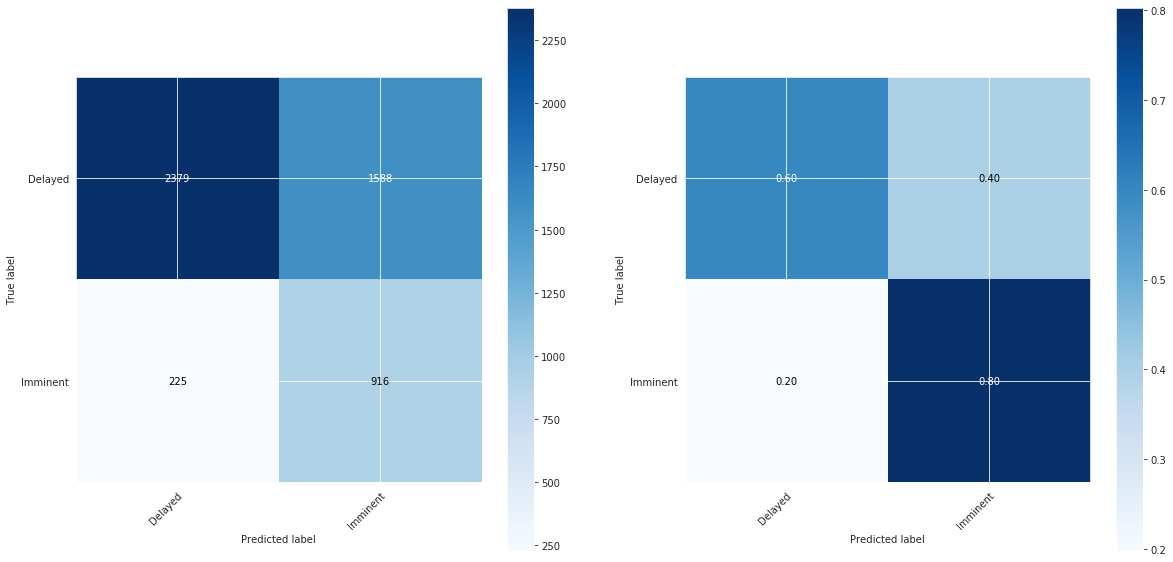

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_u+s_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

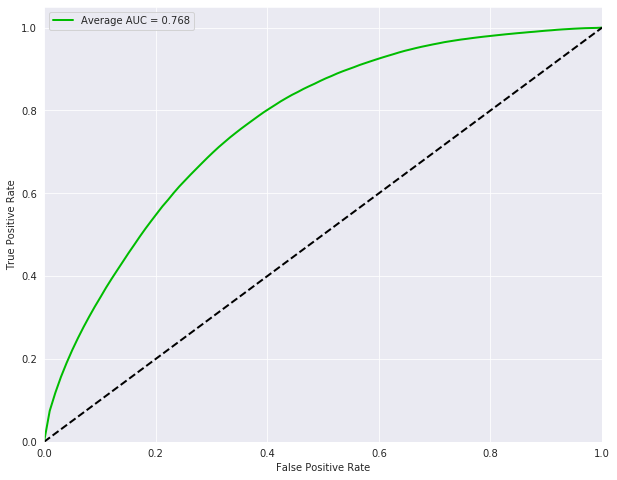

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_u+s_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)